# Edge Prediction FFN
In diesem Notebook wird das Modell für die Kantenvorhersage basierend auf den Part-IDs erstellt. Die Logik um aus diesen Wahrscheinlichkeiten, die eigentlichen Graphen zu bilden, ist in ```prediction_classes/part_predictor.py```.


In [1]:
# Import Required Libraries
import pickle
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from typing import List, Set, Tuple
from graph import Graph
import networkx as nx
import matplotlib.pyplot as plt

### Laden der Graphen

In [2]:
# Load Data
with open('data/graphs.dat', 'rb') as file:
    graphs: List[Graph] = pickle.load(file)

### Bestimmung der Vektorgröße

Bevor wir die Graphen aufteilen, ermitteln wir die höchste Part-ID. Diese Information ist entscheidend, um die Vektoren korrekt zu erstellen und das One-Hot-Encoding ordnungsgemäß durchführen zu können.

In [21]:
# Calculate Statistics

max_part_id = -1  # Initialize max_part_id

# Iterate through all graphs to calculate statistics
for graph in graphs:
    parts = graph.get_parts()
    for part in parts:
        part_id = int(part.get_part_id())
        max_part_id = max(part_id, max_part_id)

# Calculate the size of the part_id vector
size = max_part_id + 1


2271


### Datenaufteilung

Wir verwenden eine Split-Ratio von 70:15:15, um die Daten in Trainings-, Validierungs- und Testdatensätze zu unterteilen. Zunächst erfolgt jedoch lediglich eine Aufteilung in Trainings- und Testdatensätze. Der Trainingsdatensatz wird später in separate Trainings- und Validierungsdatensätze unterteilt.

In [5]:
# Splt the data into training/validation and testing
train_validation_graphs, test_graphs = train_test_split(graphs, test_size=0.15, random_state=65)

print(len(test_graphs))

1674


### Datenvorbereitung für das Feedforward-Neural-Net (FFN)

Um die Daten für das neuronale Netz nutzbar zu machen, müssen sie in eine geeignete Struktur gebracht werden:
- **Features**:
    - Der Graph wird mittels Frequency Encoding repräsentiert
    - Die Part-ID wird mittels One-Hot-Encoding verarbeitet
    - Dadurch entstehen zwei separate Vektoren:

	    1.	Ein Vektor, der das Bauteil beschreibt
	    2.	Ein Vektor, der den Graph repräsentiert

- **Target**: Das Ziel ist ebenfalls One-Hot-Encoded und zeigt, mit welchen anderen Bauteilen (Parts) das Eingabebauteil verbunden ist.

**Fragestellung**:
„Gegeben einen Graphen, mit welchen Knoten ist mein Eingabeknoten wahrscheinlich verbunden?“

In [6]:
def create_feature_targets(graph: Graph, size: int) -> Tuple[torch.Tensor, torch.Tensor]:

    # Initialize empty lists to store features and targets
    features = []
    targets = []

    # Iterate through all graphs in the training/validation set
    for graph in train_validation_graphs:
        # Get list of part IDs from the current graph and convert to integers
        part_ids_graph = graph.get_parts()
        part_ids_graph = [int(part.get_part_id()) for part in part_ids_graph]
        
        # Create one-hot encoded tensor for the entire graph's part distribution
        feature_graph = torch.zeros(size, dtype=torch.float)
        for part_id in part_ids_graph:
            feature_graph[part_id] += 1

        # Get edges from the graph
        edges = graph.get_edges()
        
        # Iterate through each edge in the graph
        for source_node, target_nodes in edges.items():
            # Get part ID of the source node
            source_id = int(source_node.get_part().get_part_id())

            # Create one-hot encoded tensor for the source part ID
            feature_source_id = torch.zeros(size, dtype=torch.float)
            feature_source_id[source_id] = 1

            # Create target tensor showing which parts are connected to source
            target = torch.zeros(size, dtype=torch.float)
            for target_node in target_nodes:
                target_id = int(target_node.get_part().get_part_id())
                target[target_id] = 1

            # Add to training data:
            # targets: which parts are connected to source
            # features: concatenation of graph distribution and source part encoding
            targets.append(target)
            features.append(torch.cat([feature_graph, feature_source_id]))

    return torch.stack(features), torch.stack(targets)

# Debugging
#torch.set_printoptions(profile="full")
#print(features[0])
#print(targets[0])

### Helper Functions

1. Funktion, die die Accuracy der Predidiction zurückgibt
2. Funktion, die relevate Metriken plottet

In [7]:
# Function to calculate the accuracy

def accuracy(y_pred, y_true):
    y_pred = y_pred > 0.5
    y_true = y_true > 0.5
    return (y_pred == y_true).float().mean()


# Plot training, validation loss and accuracy

def plot_loss_accuracy(train_loss, val_loss, val_acc):
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))

    axs[0].plot(train_loss, label='Train Loss')
    axs[0].plot(val_loss, label='Validation Loss')
    # Plot real validation los train_los + abs(train_loss - val_loss)
    axs[0].plot([x + abs(x - y) for x, y in zip(train_loss, val_loss)], label='Real Validation Loss')

    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(val_acc, label='Validation Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()



### Erstellen der Features/Targets und Splitten in Train/Validation
Wir erstellen uns die Features und Targets und teilen dann die Daten in Train und Validation auf. Wir verwenden 17% für Validation. Nachdem wir die Daten vorher schon in Train/Validation und Test aufgeteilt haben, entspricht das jetzt dem 70:15:15 Split.

In [8]:
# Prepare Data for Training

features, targets = create_feature_targets(train_validation_graphs, size)

# Split data into train, validation 17% because we alredy have separated the test data

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.17, random_state=65)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


torch.Size([60112, 4542]) torch.Size([12313, 4542]) torch.Size([60112, 2271]) torch.Size([12313, 2271])


###

### Erstellung des Modells

Da die Basisklasse auch für den anderen Ansatz verwendet wird und später im Predictor geladen werden muss, haben wir diese ausgelagert. Für das Training des Modells verwenden wir den Adam-Optimizer und Binary Cross Entropy als Loss-Funktion.

In [16]:
from ffn import FFNModel

# Initialize model
model = FFNModel(input_size=size*2, output_size=size, hidden_sizes=[1024,1024])

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

#### Training 1) "Klassisch"
Train the model using the training data and evaluate it using valdation data.

In [32]:
# Create the DataLoader

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=4096, shuffle=True)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=4096, shuffle=True)

# Track the loss and accuracy
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluation
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            validation_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    val_loss = validation_loss / len(test_loader)
    val_accuracy = accuracy(outputs, targets)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)


    print(f'Epoch {epoch+1}/{num_epochs}, Train-Loss: {train_loss}, Validation-Loss: {val_loss}, Accuracy: {val_accuracy}')



Epoch 1/10, Train-Loss: 0.4732249607642492, Validation-Loss: 0.0828682966530323, Accuracy: 0.9993835091590881
Epoch 2/10, Train-Loss: 0.01810905020684004, Validation-Loss: 0.007524191169068217, Accuracy: 0.9994891881942749
Epoch 3/10, Train-Loss: 0.008578278683125972, Validation-Loss: 0.008145837346091866, Accuracy: 0.9994011521339417
Epoch 4/10, Train-Loss: 0.007904980300615231, Validation-Loss: 0.0071171114686876535, Accuracy: 0.9993482828140259
Epoch 5/10, Train-Loss: 0.006800437780718009, Validation-Loss: 0.006261221366003156, Accuracy: 0.9992778301239014
Epoch 6/10, Train-Loss: 0.006017724703997374, Validation-Loss: 0.00586687948089093, Accuracy: 0.9992602467536926
Epoch 7/10, Train-Loss: 0.005518708595385154, Validation-Loss: 0.005325120058842003, Accuracy: 0.9993130564689636
Epoch 8/10, Train-Loss: 0.0052055403590202335, Validation-Loss: 0.005092926789075136, Accuracy: 0.9992778301239014
Epoch 9/10, Train-Loss: 0.005003945219020049, Validation-Loss: 0.004863811656832695, Accurac

### Training 2) Cross-Validation

Training mit Verwendung von Cross Validation


Fold 1
Epoch 1: Train-Loss: 0.50148617150262, Validation-Loss: 0.07395529001951218, Accuracy: 0.9993152022361755
Epoch 2: Train-Loss: 0.01598703325726092, Validation-Loss: 0.008716547396034002, Accuracy: 0.9993144869804382
Epoch 3: Train-Loss: 0.009040674776770175, Validation-Loss: 0.008720410522073507, Accuracy: 0.9993156790733337
Epoch 4: Train-Loss: 0.008156578318448737, Validation-Loss: 0.007465731585398316, Accuracy: 0.9993160367012024
Epoch 5: Train-Loss: 0.007016268355073407, Validation-Loss: 0.0065501106437295675, Accuracy: 0.9993160367012024
Epoch 6: Train-Loss: 0.00624254607828334, Validation-Loss: 0.005956173874437809, Accuracy: 0.9993151426315308
Epoch 7: Train-Loss: 0.005737697123549879, Validation-Loss: 0.005564624676480889, Accuracy: 0.9993155002593994
Epoch 8: Train-Loss: 0.005416737199993804, Validation-Loss: 0.005320905474945903, Accuracy: 0.9993160367012024
Epoch 9: Train-Loss: 0.005226763489190489, Validation-Loss: 0.005172752542421222, Accuracy: 0.9993164539337158

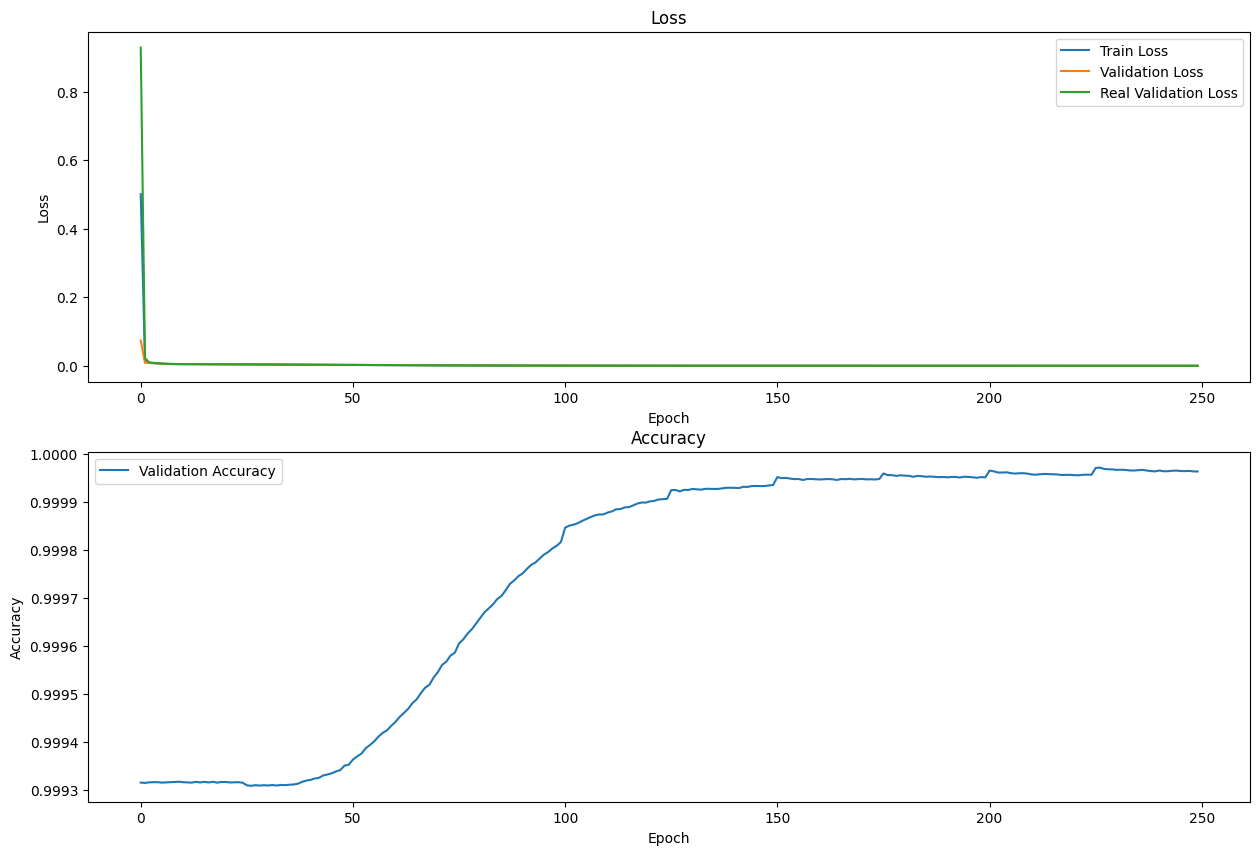

In [17]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True)

fold = 1

# Store the loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []

features, targets = create_feature_targets(train_validation_graphs, size)

for train_index, test_index in kf.split(features):
    print(f"\nFold {fold}")
    X_train, X_test = torch.stack([features[i] for i in train_index]), torch.stack([features[i] for i in test_index])
    y_train, y_test = torch.stack([targets[i] for i in train_index]), torch.stack([targets[i] for i in test_index])

    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=4096, shuffle=True)

    test_data = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_data, batch_size=4096, shuffle=True)

    for epoch in range(25):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Evaluation
        model.eval()
        validation_loss = 0.0
        total_accuracy = 0.0
        num_batches = 0
        with torch.no_grad():
            for val_inputs, val_targets in test_loader:
                outputs = model(val_inputs)
                loss = criterion(outputs, val_targets)
                validation_loss += loss.item()
                total_accuracy += accuracy(outputs, val_targets)
                num_batches += 1


        train_loss = running_loss / len(train_loader)
        val_loss = validation_loss / len(test_loader)
        avg_accuracy = total_accuracy / num_batches

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(avg_accuracy)

        print(f'Epoch {epoch+1}: Train-Loss: {train_loss}, Validation-Loss: {val_loss}, Accuracy: {avg_accuracy}')
    
    fold += 1

plot_loss_accuracy(train_losses, val_losses, train_accuracies)

### Plot von Loss und Accuracy
Um die Dynamik des Losses besser nachvollziehen zu können, habe ich die Kurve ohne die ersten 5 Epochen geplottet, da der Loss in den frühen Epochen stark abnimmt.
Eine interessante Beobachtung bei der Accuracy-Kurve ist der kurze Peak nach jedem Fold. Dieser entsteht, da die Daten, die zuvor für das Training verwendet wurden, nun Teil des Validierungsdatensatzes sind. Das Modell kann diese Daten besser vorhersagen, was zu einem kurzfristigen Anstieg der Accuracy führt.
Zudem fällt auf, dass der Unterschied im Loss zwischen Training und Validierung nahezu nicht wahrnehmbar ist. Das Modell zeigt also keine Anzeichen von Overfitting, und eine zusätzliche Regularisierung ist nicht notwendig. Mit einer Accuracy von 99,99% liefert das Modell bereits eine sehr gute Performance.

> Hinweis: Uns fiel auf, dass der Validation Loss insbesondere zu Beginn oft deutlich kleiner ausfällt als der Train Loss. Dies liegt an der Berechnungsweise: Während der Train Loss während des Trainings kontinuierlich mitprotokolliert wird, wird der Validation Loss erst am Ende jeder Epoche berechnet.

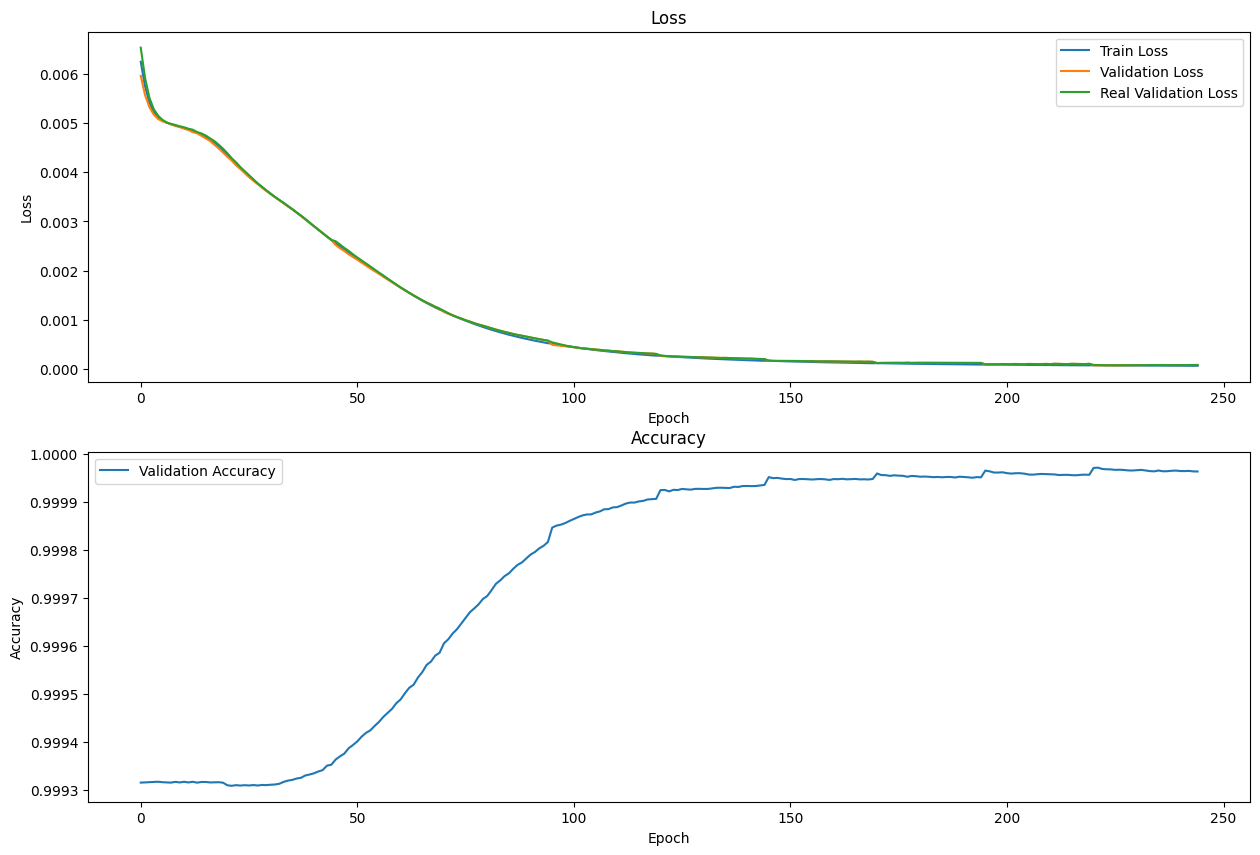

In [22]:
# Plot witout the first 5 epochs
plot_loss_accuracy(train_losses[5:], val_losses[5:], train_accuracies[5:])

### Speichern des Modells
Wir speichern uns jetzt das beste Modell ab, sodass es auch in der evaluation.py verwendet werden kann.

In [20]:
# Save the Model

torch.save(model, 'edge_prediction_models/part_edge_prediction_model.pth')

### Final Evaluation
Alternativ kann man sich auch einfach hier direkt die Metriken berechnen lassen, die von der evaluate function kommen.

In [11]:
from evaluation import evaluate
from prediction_classes.part_predictor import PartPredictor


predictor = PartPredictor()

def evaluate_model(model, eval_graphs):
    predictor = PartPredictor()

    predictor.model = model

    accuracy = evaluate(predictor, [[graph.get_parts(), graph] for graph in eval_graphs])

    return accuracy

In [18]:
print(evaluate_model(model, test_graphs))

{'edge_accuracy': 97.0532558725067, 'exact_match': 66.48745519713262}
